# THIS NOTEBOOK IS WRONG, NOT IN THE COURSE BUT SERVES AS NOTES FOR QUANTIZE TRANSFORMATIONS

After creating the docker environement,

The goal of this lab is to create a MNIST Fasion model in pytorch and experiment with the different parameters

Then, we will do the same model but fully quantized and start adapting it for FINN

## Base model creation

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    #transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor with mean and std
]);

# Load the training dataset
train_dataset = datasets.FashionMNIST(
    root='./data',  # Directory to save the dataset
    train=True,  # Load the training set
    download=True,  # Download the dataset if it doesn't exist
    transform=transform  # Apply the defined transformations
);

# Load the test dataset
test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,  # Load the test set
    download=True,
    transform=transform
)

Min :  0.0  /// Max :  0.78039217


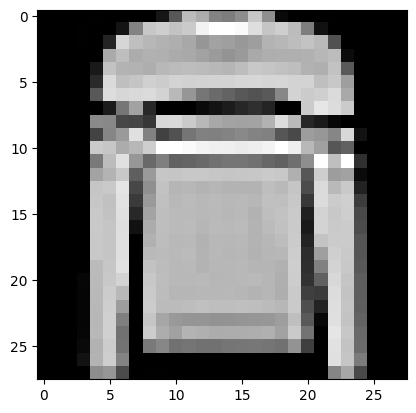

In [3]:
import matplotlib.pyplot as plt
import numpy as np

image, label = train_dataset[5]
image = np.array(image).squeeze()
print("Min : ", np.min(image[0]), " /// Max : ", np.max(image[0]))
# plot the sample

fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

In [4]:
batch_size = 100

# Create a data loader for the training set
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,  # Number of samples per batch
    shuffle=True  # Shuffle the data
)

# Create a data loader for the test set
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False  # No need to shuffle the test data
)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
input_size = 28*28
hidden1 = 64
hidden2 = 64
num_classes = 10

class SimpleFCModel(nn.Module):
    def __init__(self):
        super(SimpleFCModel, self).__init__()
        
        # Define the layers
        self.relu = nn.ReLU()                          # Activation function
        self.fc1 = nn.Linear(input_size, hidden1)  # First hidden layer
        self.fc2 = nn.Linear(hidden1, hidden2) # Second hidden layer
        self.fc3 = nn.Linear(hidden2, num_classes) # Output layer
    
    def forward(self, x):
        # Forward pass through the network
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [7]:
model = SimpleFCModel()
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
model

SimpleFCModel(
  (relu): ReLU()
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [8]:
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = torch.reshape(images, (batch_size, input_size))
        out = model(images)
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/5], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.3506
Epoch [2/5], Loss: 0.3629
Epoch [3/5], Loss: 0.4885
Epoch [4/5], Loss: 0.4001
Epoch [5/5], Loss: 0.2238


In [9]:
# test the model

model.eval()
correct = 0
total = 0
loss_total = 0

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = torch.reshape(images, (batch_size, input_size))
        out = model(images)
        _, predicted = torch.max(out.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print("accuracy =", accuracy)

accuracy = 86.38


# PART 2

This part is about creating a quantized version of the model and adapting it to finn.

In [6]:
import torch
from brevitas.nn import QuantLinear
from brevitas.nn import QuantReLU
from brevitas.nn import QuantIdentity

import torch.nn as nn

brevitas_input_size = 28 * 28
brevitas_hidden1 = 64
brevitas_hidden2 = 64
brevitas_num_classes = 10
weight_bit_width = 4
act_bit_width = 4
dropout_prob = 0.5

#is this model fully quantized or only the wieghts, i shall dig to find out once done !
brevitas_model = nn.Sequential(
    QuantLinear(brevitas_input_size, brevitas_hidden1, bias=True, weight_bit_width=weight_bit_width),
    nn.BatchNorm1d(brevitas_hidden1),
    nn.Dropout(0.5),
    QuantReLU(bit_width=act_bit_width),
    QuantLinear(brevitas_hidden1, brevitas_hidden2, bias=True, weight_bit_width=weight_bit_width),
    nn.BatchNorm1d(brevitas_hidden2),
    nn.Dropout(0.5),
    QuantReLU(bit_width=act_bit_width),
    QuantLinear(brevitas_hidden2, brevitas_num_classes, bias=True, weight_bit_width=weight_bit_width),
    QuantReLU(bit_width=act_bit_width)
)

# uncomment to check the network object
#brevitas_model

### The input data has to be quantized.

Normaly in brevistas, we can use the ```QuantIdentity()``` layer for this but unfortunatly, it does not convert to hardware (yet)

In [47]:
from torch.utils.data import Dataset

# Define a custom quantization function
def quantize_tensor(x, num_bits=8):
    qmin = 0.
    qmax = 2.**num_bits - 1.
    min_val, max_val = x.min(), x.max()

    scale = (max_val - min_val) / (qmax - qmin)
    initial_zero_point = qmin - min_val / scale

    zero_point = 0
    if initial_zero_point < qmin:
        zero_point = qmin
    elif initial_zero_point > qmax:
        zero_point = qmax
    else:
        zero_point = initial_zero_point

    zero_point = int(zero_point)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    
    return q_x.byte()

# Define the quantized transform
transform_quantized = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalize the tensor with mean and std
    transforms.Lambda(lambda x: quantize_tensor(x))  # Apply quantization
])

# Load the training dataset
train_dataset_qnt = datasets.FashionMNIST(
    root='./data',  # Directory to save the dataset
    train=True,  # Load the training set
    download=True,  # Download the dataset if it doesn't exist
    transform=transform_quantized  # Apply the defined transformations
);

# Load the test dataset
test_dataset_qnt = datasets.FashionMNIST(
    root='./data',
    train=False,  # Load the test set
    download=True,
    transform=transform_quantized
)

train_loader = DataLoader(train_dataset, 100)
test_loader = DataLoader(test_dataset, 100)

Min :  0  /// Max :  255
uint8


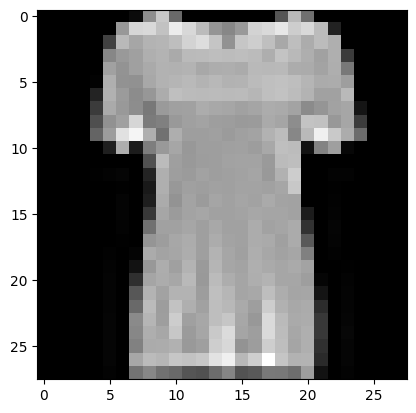

In [48]:
import matplotlib.pyplot as plt
import numpy as np

image, label = train_dataset[10]
image = np.array(image).squeeze()
print("Min : ", np.min(image), " /// Max : ", np.max(image))
print(image.dtype)
# plot the sample

fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

In [51]:
# loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(brevitas_model.parameters(), lr=0.001, betas=(0.9, 0.999))

num_epochs = 5
brevitas_model.train()

for epoch in range(num_epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = torch.reshape(images, (batch_size, 28*28))
        out = brevitas_model(images.float()) # This just make the value a float ie 255 becomes 255,0 and not 1
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/5], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.6125
Epoch [2/5], Loss: 0.4759
Epoch [3/5], Loss: 0.4846
Epoch [4/5], Loss: 0.5336
Epoch [5/5], Loss: 0.5157


In [56]:
# test the model

brevitas_model.eval()
correct = 0
total = 0
loss_total = 0

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = torch.reshape(images, (batch_size, 28*28))
        out = brevitas_model(images.float())
        _, predicted = torch.max(out.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print("accuracy =", accuracy, "%")

accuracy = 84.39 %


In [59]:
#lets have a quick look at the weights too
print(brevitas_model[0].quant_weight())
#internally, weoght are stored as float 32, here nare ways to visualize actual quantized weights :
print(brevitas_model[0].quant_weight().int())
print(brevitas_model[0].quant_weight().int().dtype)

QuantTensor(value=tensor([[ 0.0000,  0.0356,  0.1425,  ..., -0.0356, -0.0356, -0.0356],
        [ 0.0356, -0.0356, -0.0356,  ...,  0.0356, -0.0712,  0.0712],
        [-0.0356,  0.0000, -0.0356,  ...,  0.0712,  0.2137,  0.1068],
        ...,
        [-0.0712, -0.0356, -0.1068,  ...,  0.0356, -0.0712, -0.1068],
        [-0.0356,  0.0356, -0.0356,  ..., -0.1068, -0.1781, -0.1781],
        [ 0.0712,  0.0356,  0.0712,  ...,  0.0000, -0.0356, -0.1781]],
       grad_fn=<MulBackward0>), scale=tensor(0.0356, grad_fn=<DivBackward0>), zero_point=tensor(0.), bit_width=tensor(4.), signed_t=tensor(True), training_t=tensor(False))
tensor([[ 0,  1,  4,  ..., -1, -1, -1],
        [ 1, -1, -1,  ...,  1, -2,  2],
        [-1,  0, -1,  ...,  2,  6,  3],
        ...,
        [-2, -1, -3,  ...,  1, -2, -3],
        [-1,  1, -1,  ..., -3, -5, -5],
        [ 2,  1,  2,  ...,  0, -1, -5]], dtype=torch.int8)
torch.int8


In [60]:
# Model wrapper to :
# - make sure the model can rack in bipolar data, we just saw so no need for that
# - add a binary quantizer on the output whith bipolar behavior
# note to myself, may have to rework that output quantizer (or just do no pre/post, also works fine
from brevitas.nn import QuantIdentity


class ModelForExport(nn.Module):
    def __init__(self, my_pretrained_model):
        super(ModelForExport, self).__init__()
        self.pretrained = my_pretrained_model
    
    def forward(self, x):
        out= self.pretrained(x)
        return out

model_for_export = ModelForExport(brevitas_model)

In [63]:
# test the model

model_for_export.eval()
correct = 0
total = 0
loss_total = 0

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = torch.reshape(images, (batch_size, 28*28))
        out = model_for_export(images.float())
        _, predicted = torch.max(out.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print("accuracy =", accuracy)

accuracy = 84.39


# PART 3

Exporting the model and visualizing it

In [82]:
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.core.datatype import DataType
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN

filename = "/tmp/finn_dev_rootmin/LAB_1.onnx"
filename_clean = "/tmp/finn_dev_rootmin/LAB1_clean.onnx"

def asymmetric_quantize(arr, num_bits=8):
    min = 0
    max = 2**num_bits - 1
    
    beta = np.min(arr)
    alpha = np.max(arr)
    scale = (alpha - beta) / max
    zero_point = np.clip((-beta/scale),0,max).round().astype(np.int8)

    quantized_arr = np.clip(np.round(arr / scale + zero_point), min, max).astype(np.float32)
    
    return quantized_arr

#Crete a tensor ressembling the input tensor we saw earlier
input_a = np.random.rand(1,28*28).astype(np.float32)
input_a = asymmetric_quantize(input_a)
print(np.max(input_a[0]))
scale = 1.0
input_t = torch.from_numpy(input_a * scale)

# Export to ONNX
export_qonnx(
    model_for_export, export_path=filename, input_t=input_t
)

# clean-up
qonnx_cleanup(filename, out_file=filename_clean)

# ModelWrapper
model = ModelWrapper(filename_clean)
# Setting the input datatype explicitly because it doesn't get derived from the export function
model.set_tensor_datatype(model.graph.input[0].name, DataType["UINT8"])
model = model.transform(ConvertQONNXtoFINN())
model.save("/tmp/finn_dev_rootmin/ready_finn.onnx")

print("Model saved to /tmp/finn_dev_rootmin/ready_finn.onnx")

255.0
Model saved to /tmp/finn_dev_rootmin/ready_finn.onnx


/home/rootmin/Documents/freelance/mission2/finn/deps/qonnx/src/qonnx/transformation/gemm_to_matmul.py:57: UserWarning: The GemmToMatMul transformation only offers explicit support for version 9 of the Gemm node, but the ONNX version of the supplied model is 14. Thus the transformation may fail or return incomplete results.
  warnings.warn(


In [84]:
from finn.util.visualization import showInNetron

showInNetron("/tmp/finn_dev_rootmin/ready_finn.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_rootmin/ready_finn.onnx' at http://0.0.0.0:8081


In [ ]:
showInNetron(filename_clean)

In [ ]:
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.core.datatype import DataType

filename_final = "/tmp/finn_dev_rootmin/LAB1_finnonnx.onnx"

# Create a model wrapper, convert to FINN
model = ModelWrapper(filename_clean)
# this is because we saw the input range from -1 to 1 but may have to be reworked
model.set_tensor_datatype(model.graph.input[0].name, DataType["BIPOLAR"])
model = model.transform(ConvertQONNXtoFINN())
model.save(filename_final)

print("Model saved to %s" % filename_final)

In [ ]:
showInNetron(filename_final)